## Stacking the Best Models
<pre><b>This Kernel shows how the scores can be improved using Stacking Method.
Credit Goes to the following kernels
ref:
1. https://www.kaggle.com/filemide/distance-criskiev-hyparam-cont-1-662
2. https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481
3. https://www.kaggle.com/marcelotamashiro/lgb-public-kernels-plus-more-features
4. https://www.kaggle.com/scaomath/no-memory-reduction-workflow-for-each-type-lb-1-28
5. https://www.kaggle.com/fnands/1-mpnn/output?scriptVersionId=18233432
6. https://www.kaggle.com/harshit92/fork-from-kernel-1-481
7. https://www.kaggle.com/xwxw2929/keras-neural-net-and-distance-features
8. https://www.kaggle.com/marcogorelli/criskiev-s-distances-more-estimators-groupkfold?scriptVersionId=18843561
9. https://www.kaggle.com/toshik/schnet-starter-kit
10.https://www.kaggle.com/abazdyrev/nn-w-o-skew

</b></pre>

## Stat Stack

In [3]:
nb = '99-04'

In [4]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
import seaborn as sns
%matplotlib inline
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

champs-scalar-coupling



In [19]:
sub_path = './../output'
all_files = [
# 'nb60_submission_lgb_-1.5330660525700779.csv',
# 'nb79_submission_extra_trees_regressor_-1.56760.csv',
# 'nb80_submission_extra_trees_regressor_-1.48000.csv',
# 'nb81_submission_bagging_regressor_-1.44452.csv',
# 'nb84_submission_extra_trees_regressor_-1.60943.csv',
# 'nb85_submission_extra_trees_regressor_-1.52972.csv',
# 'nb88_submission_lgb_-1.547953965914086.csv',
# 'nb91_submission_extra_trees_regressor_-1.47467.csv',
# 'nb91_stack_submission_lgb_-1.7348780297791941.csv',
'nb95_stack_submission_ridge_-1.74195.csv',
# 'nb95_stack_submission_lasso_-1.74192.csv',
'nb96_stack_submission_extra_trees_regressor_-1.79030.csv',
'nb99_stack_submission_random_forest_regressor_-1.78717.csv',
'nb99-01_stack_submission_lgb_-1.75427.csv',
    
'keras_newral_net_pl_-1.67.csv',
'stack_median-1.839.csv',
'stack_median-1.895.csv',
]

In [20]:
import warnings
warnings.filterwarnings("ignore")
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "mol" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()
ncol = concat_sub.shape[1]

In [21]:
# check correlation
concat_sub.iloc[:,1:].corr()

,mol0,mol1,mol2,mol3,mol4,mol5,mol6
mol0,1.000000,0.999994,0.999993,0.999897,0.999910,0.999973,0.999972
mol1,0.999994,1.000000,0.999998,0.999898,0.999908,0.999971,0.999971
mol2,0.999993,0.999998,1.000000,0.999897,0.999907,0.999969,0.999969
mol3,0.999897,0.999898,0.999897,1.000000,0.999813,0.999881,0.999879
mol4,0.999910,0.999908,0.999907,0.999813,1.000000,0.999921,0.999946
mol5,0.999973,0.999971,0.999969,0.999881,0.999921,1.000000,0.999993
mol6,0.999972,0.999971,0.999969,0.999879,0.999946,0.999993,1.000000


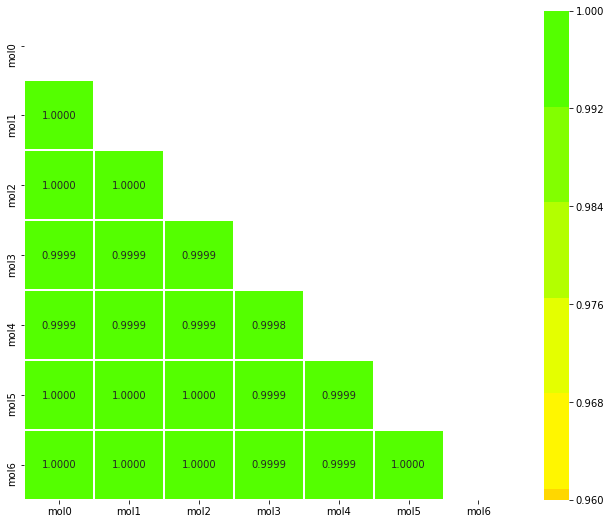

In [22]:
corr = concat_sub.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='prism', vmin=0.96, center=0, square=True, linewidths=1, annot=True, fmt='.4f')

In [23]:
# get the data fields ready for stacking
concat_sub['m_max'] = concat_sub.iloc[:, 1:].max(axis=1)
concat_sub['m_min'] = concat_sub.iloc[:, 1:].min(axis=1)
concat_sub['m_median'] = concat_sub.iloc[:, 1:].median(axis=1)

In [24]:
concat_sub.describe()

,id,mol0,mol1,mol2,mol3,mol4,mol5,mol6,m_max,m_min,m_median
count,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06
mean,5.910918e+06,1.588586e+01,1.588693e+01,1.588691e+01,1.588677e+01,1.588054e+01,1.588402e+01,1.588214e+01,1.605304e+01,1.571519e+01,1.588566e+01
std,7.232878e+05,3.486702e+01,3.486620e+01,3.486627e+01,3.486281e+01,3.485870e+01,3.486948e+01,3.486402e+01,3.497984e+01,3.474532e+01,3.486573e+01
min,4.658147e+06,-3.404520e+01,-3.555385e+01,-3.468478e+01,-2.145506e+01,-3.309956e+01,-3.182835e+01,-3.247023e+01,-2.142577e+01,-3.555385e+01,-3.247023e+01
25%,5.284532e+06,-2.433566e-01,-2.395595e-01,-2.397829e-01,-2.404052e-01,-2.461876e-01,-2.346575e-01,-2.383975e-01,-1.582286e-01,-3.270452e-01,-2.384158e-01
50%,5.910918e+06,2.270687e+00,2.284073e+00,2.284591e+00,2.283506e+00,2.278162e+00,2.276488e+00,2.277052e+00,2.383712e+00,2.168229e+00,2.280198e+00
75%,6.537303e+06,7.371257e+00,7.358291e+00,7.357825e+00,7.366622e+00,7.355285e+00,7.335617e+00,7.343839e+00,7.532663e+00,7.177133e+00,7.355621e+00
max,7.163688e+06,2.039126e+02,2.037053e+02,2.037652e+02,2.016330e+02,2.844774e+02,2.033392e+02,2.039927e+02,2.844774e+02,1.991205e+02,2.037652e+02


In [25]:
cutoff_lo = 0.8
cutoff_hi = 0.2

# Mean Stacking

In [26]:
rank = np.tril(concat_sub.iloc[:,1:ncol].corr().values,-1)
m_gmean = 0
n = 8
while rank.max()>0:
    mx = np.unravel_index(rank.argmax(), rank.shape)
    m_gmean += n*(np.log(concat_sub.iloc[:, mx[0]+1]) + np.log(concat_sub.iloc[:, mx[1]+1]))/2
    rank[mx] = 0
    n += 1

In [27]:
concat_sub['m_mean'] = np.exp(m_gmean/(n-1)**2)

# Median Stacking

In [28]:
path_submission = f'../output/nb{nb}_stack_median_submission.csv'
print(f'save pash: {path_submission}')

concat_sub['scalar_coupling_constant'] = concat_sub['m_median']
concat_sub[['id', 'scalar_coupling_constant']].to_csv(path_submission, 
                                        index=False, float_format='%.6f')

save pash: ../output/nb99-04_stack_median_submission.csv


In [29]:
df = pd.read_csv(path_submission)
df.head()

,id,scalar_coupling_constant
0,4658147,12.460295
1,4658148,181.579120
2,4658149,11.289299
3,4658150,165.912134
4,4658151,12.360014


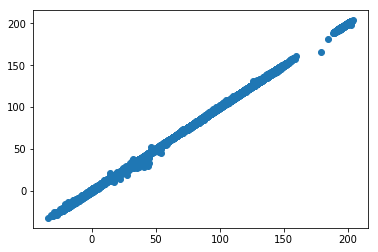

In [30]:
plt.scatter(outs[0].scalar_coupling_constant.values, df.scalar_coupling_constant.values)

# Pushout + Median Stacking
>* Pushout strategy is bit aggresive

# MinMax + Mean Stacking
>* MinMax seems more gentle and it outperforms the previous one

# MinMax + Median Stacking

## Averaging Ranks

Best Results : Stack Median

# Blending Approach